In [1]:
# only for standard_env, not ps_msc
# from tf_bind_8_dataset import TFBind8Dataset

In [2]:
import torch
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU found')

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import numpy as np
from collections import defaultdict
import random
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [5]:
from ps_functions.mlp_model import train_mlp_from_config
from ps_functions.cnn_model import train_cnn_from_config
from ps_functions.lstm_model import train_lstm_from_config
from ps_functions.lstm_cnn_model import train_lstm_cnn_from_config
from ps_functions.cnn_lstm_model import train_cnn_lstm_from_config
from ps_functions.transformer_model import train_transformer_from_config
from ps_functions.evaluate_best_models import run_evaluation
from ps_functions.evaluate_best_models import predict_y_values

In [6]:
print('toggle')

toggle


## Data Loading

In [7]:
class TFBind8Dataset():
    def __init__(self):
        self.x = np.load(os.path.join('data', 'x_SIX6_REF_R1.npy'))
        self.y = np.load(os.path.join('data', 'y_SIX6_REF_R1.npy'))

dataset = TFBind8Dataset()

In [8]:
# dataset = TFBind8Dataset(
#     base_path='C:/Users/kroep/Desktop/AI/ps_master_new/code/data_from_huggingface/',
#     transcription_factor="SIX6_REF_R1"
# )

# import os
# import numpy as np
# np.save(os.path.join('data', 'x_SIX6_REF_R1.npy'), dataset.x)   # save x array
# np.save(os.path.join('data', 'y_SIX6_REF_R1.npy'), dataset.y)   # save x array

In [9]:
dataset.y.flatten()

array([0.5247495 , 0.36651134, 0.44675916, ..., 0.4864553 , 0.44948047,
       0.6796169 ], shape=(65792,), dtype=float32)

## Data Analysis

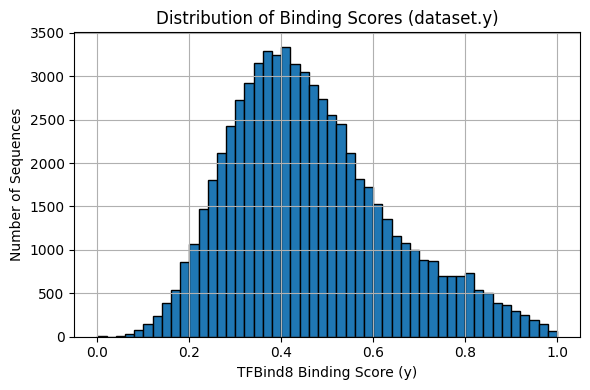

In [10]:
y_values = dataset.y.flatten()

def plot_y_values(y_values):
    # Plot the histogram of y values
    plt.figure(figsize=(6, 4))
    plt.hist(y_values, bins=50, edgecolor='black')
    plt.xlabel("TFBind8 Binding Score (y)")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Binding Scores (dataset.y)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_y_values(y_values)

In [11]:
sequence_tuples = [tuple(seq) for seq in dataset.x]
seq_counts = Counter(sequence_tuples)
num_occurring_twice = sum(1 for count in seq_counts.values() if count == 2)

print(f"Number of sequences occurring exactly 2 times: {num_occurring_twice}")

Number of sequences occurring exactly 2 times: 256


In [12]:
seq_counts = Counter(sequence_tuples)

In [13]:
dataset.x[100]

array([0, 0, 0, 0, 1, 2, 1, 0], dtype=int32)

In [14]:
for i, sequ in enumerate(dataset.x):
    if (sequ == (0, 0, 2, 2, 1, 1, 3, 3)).all():
        print(f'index {i}: found {sequ} with a y-value of {dataset.y[i]}')

index 2608: found [0 0 2 2 1 1 3 3] with a y-value of [0.07736156]
index 35504: found [0 0 2 2 1 1 3 3] with a y-value of [0.07736156]


C:\Users\kroep\AppData\Local\Temp\ipykernel_11144\1999095031.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mutation_effects[n] for n in [1, 2, 3]], labels=["1 mutation", "2 mutations", "3 mutations"])


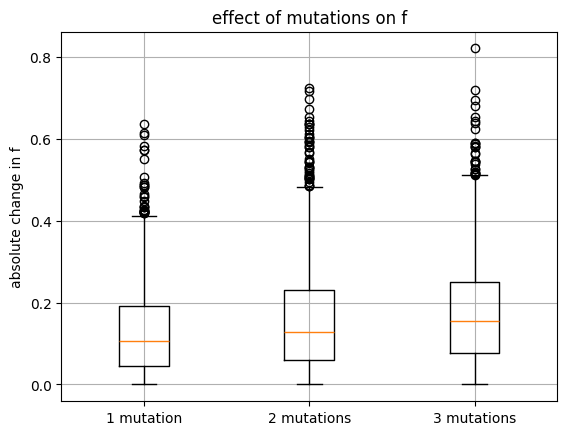

In [15]:
# get all mutated versions of a sequence with n mutations
def mutate_sequence(seq, num_mutations=1):
    seq = np.array(seq)
    mutated_seqs = []
    positions = list(range(len(seq)))

    for _ in range(25):  # 25 random combinations per sample
        pos_to_mutate = random.sample(positions, num_mutations)
        mutated = seq.copy()
        for pos in pos_to_mutate:
            original_base = seq[pos]
            possible_bases = [b for b in range(4) if b != original_base]
            mutated[pos] = random.choice(possible_bases)
        mutated_seqs.append(mutated)
    
    return mutated_seqs

# calculate avg absolute change in f for 50 randomly selected sequences
# when mutating a sequence up to 3 times
def compute_mutation_effects(dataset_x, dataset_y, mutation_counts=[1, 2, 3]):
    results = defaultdict(list)
    indices = np.random.choice(len(dataset_x), 50, replace=False)

    for idx in indices:
        original_seq = dataset_x[idx]
        original_y = dataset_y[idx][0]  # y is shape (N,1)

        for n_mut in mutation_counts:
            mutated_variants = mutate_sequence(original_seq, num_mutations=n_mut)

            for var in mutated_variants:
                matches = np.all(dataset_x == var, axis=1)
                if np.any(matches):
                    matched_y = dataset_y[matches][0][0]
                    delta = abs(original_y - matched_y)
                    results[n_mut].append(delta)
    
    return results

# Compute average changes
mutation_effects = compute_mutation_effects(dataset.x, dataset.y)

plt.boxplot([mutation_effects[n] for n in [1, 2, 3]], labels=["1 mutation", "2 mutations", "3 mutations"])
plt.ylabel("absolute change in f")
plt.title("effect of mutations on f")
plt.grid(True)
plt.show()

## Dataset Split

**Notes:**
- Take a random sequence in the dataset and get all mutations up to 6. That data is then split into training and validation sets.
- For testing we want to create an Out-Of-Distribution Dataset, which is the reaming data, so 7 and 8 mutations in this case.

In [16]:
# only select unique occurences
x_data, unique_indices = np.unique(dataset.x, axis=0, return_index=True)
y_data = dataset.y[unique_indices]

In [17]:
len(dataset.x) == len(x_data) + num_occurring_twice

True

In [18]:
# select a random anchor for the mutation dataset
np.random.seed(42)
anchor_idx = np.random.choice(len(x_data))
anchor_seq = x_data[anchor_idx]

# hamming distances for randomly selected anchorr
mutation_distances = np.array([np.sum(seq != anchor_seq) for seq in x_data])

# create mutation set (1–5 mutations away from anchor)
mutation_mask = (mutation_distances >= 1) & (mutation_distances <= 6)
x_max_6_mutations = x_data[mutation_mask]
y_max_6_mutations = y_data[mutation_mask]

x_train, x_temp, y_train, y_temp = train_test_split(x_max_6_mutations, y_max_6_mutations, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

(len(x_data), len(x_max_6_mutations), len(x_train), len(x_val), len(x_test))

(65536, 41478, 33182, 4148, 4148)

In [19]:
dataset.x.shape

(65792, 8)

In [20]:
mutation_mask = (mutation_distances == 7)
x_7_mutations = x_data[mutation_mask]
y_7_mutations = y_data[mutation_mask]

mutation_mask = (mutation_distances == 8)
x_8_mutations = x_data[mutation_mask]
y_8_mutations = y_data[mutation_mask]

len(x_data) - 1 == len(x_max_6_mutations) + len(x_7_mutations) + len(x_8_mutations)

True

In [21]:
# # get remaining data and make the dataset split
# remaining_mask = ~mutation_mask
# x_geq_6_mutations = x_data[remaining_mask]
# y_geq_6_remaining = y_data[remaining_mask]
# len(x_geq_6_mutations)

# len(x_train)+len(x_val)+len(x_test) == len(x_max_6_mutations)

## Train RF Baseline

In [22]:
tree_counts_safe = [101, 501, 1001, 1501]
results_safe = []

best_mae = float("inf")
rf_scorer = None

for n_trees in tree_counts_safe:
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=42, n_jobs=1)
    rf.fit(x_train, y_train.ravel())

    y_pred_rf = rf.predict(x_val)
    mae_rf = mean_absolute_error(y_val, y_pred_rf)
    results_safe.append((n_trees, mae_rf))

    if mae_rf < best_mae:
        best_mae = mae_rf
        rf_scorer = rf

df_results = pd.DataFrame(results_safe, columns=["n_trees", "MAE"])
df_results

n_trees       MAE
0      101  0.079437
1      501  0.079159
2     1001  0.079125
3     1501  0.079117

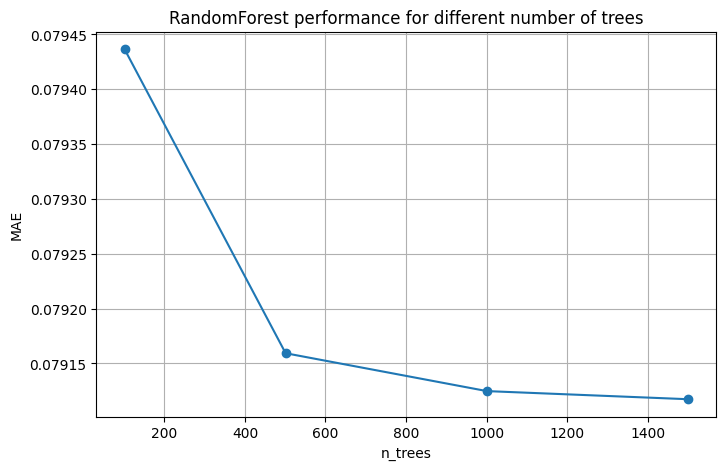

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(df_results["n_trees"], df_results["MAE"], marker='o')
plt.xlabel("n_trees")
plt.ylabel("MAE")
plt.title("RandomForest performance for different number of trees")
plt.grid(True)
plt.show()

In [24]:
y_pred_test = rf_scorer.predict(x_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
error_std_test = np.std(np.abs(y_pred_test - y_test))

y_pred_7_mutations = rf_scorer.predict(x_7_mutations)
mae_7_mutations = mean_absolute_error(y_7_mutations, y_pred_7_mutations)
error_std_7_mutations = np.std(np.abs(y_pred_7_mutations - y_7_mutations))

y_pred_8_mutations = rf_scorer.predict(x_8_mutations)
mae_8_mutations = mean_absolute_error(y_8_mutations, y_pred_8_mutations)
error_std_8_mutations = np.std(np.abs(y_pred_8_mutations - y_8_mutations))

In [25]:
df_rf_perf = pd.DataFrame({
    'model': ['rf'],
    'test_mae': [mae_test],
    'test_std': [error_std_test],
    'ood_7_mut_mae': [mae_7_mutations],
    'ood_7_mut_std': [error_std_7_mutations],
    'ood_8_mut_mae': [mae_8_mutations],
    'ood_8_mut_std': [error_std_8_mutations]
})

df_rf_perf

model  test_mae  test_std  ood_7_mut_mae  ood_7_mut_std  ood_8_mut_mae  \
0    rf    0.0789  0.139323       0.088567       0.138423       0.105527   

   ood_8_mut_std  
0       0.136205

## Hyperparameter Search

In [26]:
shared_training_config = {
    "epochs": 400,
    "eval_every": 5,
    "early_stopping_patience": 20
}

with open('search_spaces/shared_training_config.json', 'w') as f:
    json.dump(shared_training_config, f, indent=3)

In [27]:
'''training = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.0, 0.01],
    "loss": ["mae", "mse"]
}'''

training = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.0, 0.01, 0.001, 0.0001],
    "loss": ["mae", "mse"]
}

In [28]:
'''mlp_search_space = {
  "model": {
    "hidden_dims": [32, 64, 128],
    "num_layers": [2, 3, 4],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/mlp_search_space.json', 'w') as f:
    json.dump(mlp_search_space, f, indent=2)'''

'''
mlp_search_space = {
  "model": {
    "hidden_dims": [32, 48, 64],
    "num_layers": [2, 3],
    "dropout_input": [0.15, 0.2],
    "dropout_hidden": [0.4, 0.5, 0.6]
  },
  "training": training
}
'''

mlp_search_space = {
  "model": {
    "hidden_dims": [32, 64, 128, 256],
    "num_layers": [2, 3, 4],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/mlp_search_space.json', 'w') as f:
    json.dump(mlp_search_space, f, indent=2)

In [29]:
'''cnn_search_space = {
  "model": {
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64, 128]
  },
  "training": training
}

with open('search_spaces/cnn_search_space.json', 'w') as f:
    json.dump(cnn_search_space, f, indent=2)'''

'''cnn_search_space = {
  "model": {
    "channels": [[32, 64], [48, 96]],
    "kernel_size": [3],
    "fc_dim": [64, 96],
    "dropout_input": [0.1, 0.15, 0.2],
    "dropout_hidden": [0.4, 0.5, 0.6]
  },
  "training": training
}'''

cnn_search_space = {
  "model": {
    "channels": [
          [32, 64],
          [48, 96],
          [64, 128],
          [32, 64, 128],
          [48, 96, 192]
        ],
        # cover pointwise to wide context (seq_len=8)
        "kernel_size": [1, 3, 5, 7],
        # widen FC head capacity
        "fc_dim": [64, 96, 128, 192, 256],
        # regularization sweep
        "dropout_input": [0.0, 0.1, 0.15, 0.2, 0.3],
        "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/cnn_search_space.json', 'w') as f:
    json.dump(cnn_search_space, f, indent=2)

In [30]:
'''lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64, 128],
    "num_layers": [1, 2, 3],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "fc_dim": [64, 128, 256],
    "bidirectional": [True, False]
  },
  "training": training
}

with open('search_spaces/lstm_search_space.json', 'w') as f:
    json.dump(lstm_search_space, f, indent=2)'''

'''
lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64],
    "num_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6],
    "fc_dim": [64, 128],
    "bidirectional": [True]
  },
  "training": training
}
'''

lstm_search_space = {
  "model": {
    "hidden_dim": [32, 64, 128, 192, 256],
    "num_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "fc_dim": [64, 96, 128, 192, 256],
    "bidirectional": [True, False]
  },
  "training": training
}

with open('search_spaces/lstm_search_space.json', 'w') as f:
    json.dump(lstm_search_space, f, indent=2)

In [31]:
'''lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64]
  },
  "training": training
}

with open('search_spaces/lstm_cnn_search_space.json', 'w') as f:
    json.dump(lstm_cnn_search_space, f, indent=2)'''

'''lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6],
    "cnn_channels": [[32, 64], [48, 96]],
    "kernel_size": [3],
    "fc_dim": [32, 64],
    "bidirectional": [True, False]
  },
  "training": training
}'''

lstm_cnn_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64, 128, 192, 256],
    "lstm_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [
      [32, 64],
      [48, 96],
      [64, 128],
      [32, 64, 128],
      [48, 96, 192]
    ],
    "kernel_size": [1, 3, 5, 7],
    "fc_dim": [64, 96, 128, 192, 256]
  },
  "training": training
}

with open('search_spaces/lstm_cnn_search_space.json', 'w') as f:
    json.dump(lstm_cnn_search_space, f, indent=2)

In [32]:
'''cnn_lstm_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64],
    "lstm_layers": [1, 2],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [[32, 64], [64, 128]],
    "kernel_size": [3, 5],
    "fc_dim": [32, 64]
  },
  "training": training
}

with open('search_spaces/cnn_lstm_search_space.json', 'w') as f:
    json.dump(cnn_lstm_search_space, f, indent=2)'''

'''cnn_lstm_search_space = {
  "model": {
    "cnn_channels": [[32, 64]],
    "kernel_size": [3],
    "lstm_hidden_dim": [32],
    "lstm_layers": [1],
    "fc_dim": [32, 64],
    "dropout_input": [0.2],
    "dropout_hidden": [0.5, 0.6],
    "bidirectional": [True, False]
  },
  "training": training
}'''

cnn_lstm_search_space = {
  "model": {
    "lstm_hidden_dim": [32, 64, 128, 192, 256],
    "lstm_layers": [1, 2, 3],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.3, 0.4, 0.5, 0.6, 0.7],
    "bidirectional": [True, False],
    "cnn_channels": [
      [32, 64],
      [48, 96],
      [64, 128],
      [32, 64, 128],
      [48, 96, 192]
    ],
    "kernel_size": [1, 3, 5, 7],
    "fc_dim": [64, 96, 128, 192, 256]
  },
  "training": training
}

with open('search_spaces/cnn_lstm_search_space.json', 'w') as f:
    json.dump(cnn_lstm_search_space, f, indent=2)

In [33]:
'''transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [32, 64, 128],
    "nhead": [2, 4, 8],
    "num_layers": [1, 2, 3],
    "dim_feedforward": [64, 128, 256],
    "dropout_input": [0.1, 0.2],
    "dropout_hidden": [0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/transformer_search_space.json', 'w') as f:
    json.dump(transformer_search_space, f, indent=2)'''

'''transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [48, 64],
    "nhead": [2, 4],
    "num_layers": [1, 2],
    "dim_feedforward": [128],
    "dropout_input": [0.2],
    "dropout_hidden": [0.5, 0.6]
  },
  "training": training
}'''

transformer_search_space = {
  "model": {
    "seq_len": [8],
    "d_model": [32, 48, 64, 96, 128],
    "nhead": [2, 4, 8],
    "num_layers": [1, 2, 3],
    "dim_feedforward": [128, 256, 384, 512],
    "dropout_input": [0.0, 0.1, 0.2, 0.3],
    "dropout_hidden": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
  },
  "training": training
}

with open('search_spaces/transformer_search_space.json', 'w') as f:
    json.dump(transformer_search_space, f, indent=2)

### Random Search

In [34]:
from ps_functions.random_search import random_search

train_fns = {
    "mlp": train_mlp_from_config,
    "cnn": train_cnn_from_config,
    "lstm": train_lstm_from_config,
    "lstm_cnn": train_lstm_cnn_from_config,
    "cnn_lstm": train_cnn_lstm_from_config,
    "transformer": train_transformer_from_config
}

search_paths = {
    "mlp": "search_spaces/mlp_search_space.json",
    "cnn": "search_spaces/cnn_search_space.json",
    "lstm": "search_spaces/lstm_search_space.json",
    "lstm_cnn": "search_spaces/lstm_cnn_search_space.json",
    "cnn_lstm": "search_spaces/cnn_lstm_search_space.json",
    "transformer": "search_spaces/transformer_search_space.json"
}

# rs_hyperparameter_folder = random_search(train_fns, search_paths, x_train, y_train, x_val, y_val, n_trials=30)

## Evaluate Models

#### Numerical Analysis

In [35]:
rs_hyperparameter_folders = [
    'results\\training\\random_search_2025-07-20-00-31',
    'results\\training\\random_search_2025-07-25-00-05',
    'results\\training\\random_search_2025-09-27-21-41',
    'results\\training\\random_search_2025-09-30-21-49',
    'results\\training\\random_search_2025-10-02-08-04'
]

In [36]:
def load_runs(folder):
    df_results = pd.read_csv(f'{(folder)}\\configurations.csv')
    df_summary= pd.read_csv(f'{(folder)}\\summary.csv')
    df_results['best_mae'] = df_summary['best_mae']
    df_results['val_error_std'] = df_summary['val_error_std']
    return df_results

In [37]:
def load_folders(folder_list):
    dfs = []
    for folder in folder_list:
        df = load_runs(folder)
        df['folder'] = folder
        df['run_name'] = os.path.basename(folder)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_loaded = load_folders(rs_hyperparameter_folders)

df_loaded[df_loaded.best_mae<0.07][
    ['model_class', 'trial', 'best_mae', 'val_error_std', 'folder']].model_class.value_counts().to_dict()

{'lstm': 49, 'cnn_lstm': 12, 'lstm_cnn': 2}

In [38]:
results = df_rf_perf.to_dict('records')

for model_class in df_loaded.model_class.unique():
    
    best_idx = int(df_loaded[df_loaded.model_class==model_class].best_mae.idxmin())
    best_row = df_loaded.iloc[best_idx]
    best_rs_hyperparameter_folder = best_row.folder
    
    print(best_rs_hyperparameter_folder)
    
    results += run_evaluation(
        folder=best_rs_hyperparameter_folder,
        model_names=[model_class],
        x_test=x_test,
        y_test=y_test,
        x_ood_7=x_7_mutations,
        y_ood_7=y_7_mutations,
        x_ood_8=x_8_mutations,
        y_ood_8=y_8_mutations
    )

results\training\random_search_2025-10-02-08-04
Evaluating mlp: mlp



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start

 mlp: Test MAE = 0.0755, std = 0.1350, OOD 7 MAE = 0.0972, std = 0.1347, OOD 8 MAE = 0.1231, std = 0.1383
results\training\random_search_2025-10-02-08-04
Evaluating cnn: cnn
 cnn: Test MAE = 0.0758, std = 0.1357, OOD 7 MAE = 0.0773, std = 0.1404, OOD 8 MAE = 0.0799, std = 0.1461
results\training\random_search_2025-09-27-21-41
Evaluating lstm: lstm


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=tor

 lstm: Test MAE = 0.0675, std = 0.1416, OOD 7 MAE = 0.0686, std = 0.1447, OOD 8 MAE = 0.0739, std = 0.1448
results\training\random_search_2025-10-02-08-04
Evaluating lstm_cnn: lstm_cnn


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=tor

 lstm_cnn: Test MAE = 0.0685, std = 0.1401, OOD 7 MAE = 0.0732, std = 0.1425, OOD 8 MAE = 0.0863, std = 0.1443
results\training\random_search_2025-10-02-08-04
Evaluating cnn_lstm: cnn_lstm


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=tor

 cnn_lstm: Test MAE = 0.0676, std = 0.1424, OOD 7 MAE = 0.0729, std = 0.1445, OOD 8 MAE = 0.0905, std = 0.1454
results\training\random_search_2025-10-02-08-04
Evaluating transformer: transformer


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x_data, dtype=tor

 transformer: Test MAE = 0.0765, std = 0.1427, OOD 7 MAE = 0.0878, std = 0.1386, OOD 8 MAE = 0.1114, std = 0.1371


In [39]:
df_results = pd.DataFrame(results)
df_results

model  test_mae  test_std  ood_7_mut_mae  ood_7_mut_std  \
0           rf  0.078900  0.139323       0.088567       0.138423   
1          mlp  0.075498  0.134985       0.097226       0.134710   
2          cnn  0.075773  0.135665       0.077310       0.140370   
3         lstm  0.067494  0.141612       0.068645       0.144731   
4     lstm_cnn  0.068505  0.140107       0.073183       0.142503   
5     cnn_lstm  0.067556  0.142433       0.072915       0.144474   
6  transformer  0.076458  0.142710       0.087806       0.138624   

   ood_8_mut_mae  ood_8_mut_std  
0       0.105527       0.136205  
1       0.123145       0.138334  
2       0.079926       0.146108  
3       0.073855       0.144793  
4       0.086270       0.144333  
5       0.090513       0.145448  
6       0.111440       0.137136

#### Visual Analysis

In [40]:
def plot_mae_with_downward_std(df):
    labels = df["model"].tolist()
    x = np.arange(len(labels))
    width = 0.25
    
    mae_sets = [
        ("Test MAE", df["test_mae"], df["test_std"]),
        ("OOD 7 Mut MAE", df["ood_7_mut_mae"], df["ood_7_mut_std"]),
        ("OOD 8 Mut MAE", df["ood_8_mut_mae"], df["ood_8_mut_std"])
    ]

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (label, maes, stds) in enumerate(mae_sets):
        # MAE plot
        ax.bar(x + (i - 1) * width, maes, width, label=label)
        # STD plot (below)
        ax.bar(x + (i - 1) * width, -stds, width, alpha=0.4, color='gray')

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel("MAE (↑)                 \nand STD (↓)                 ", rotation=0)

    ax.set_title("Model MAE and Standard Deviation (Downward)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

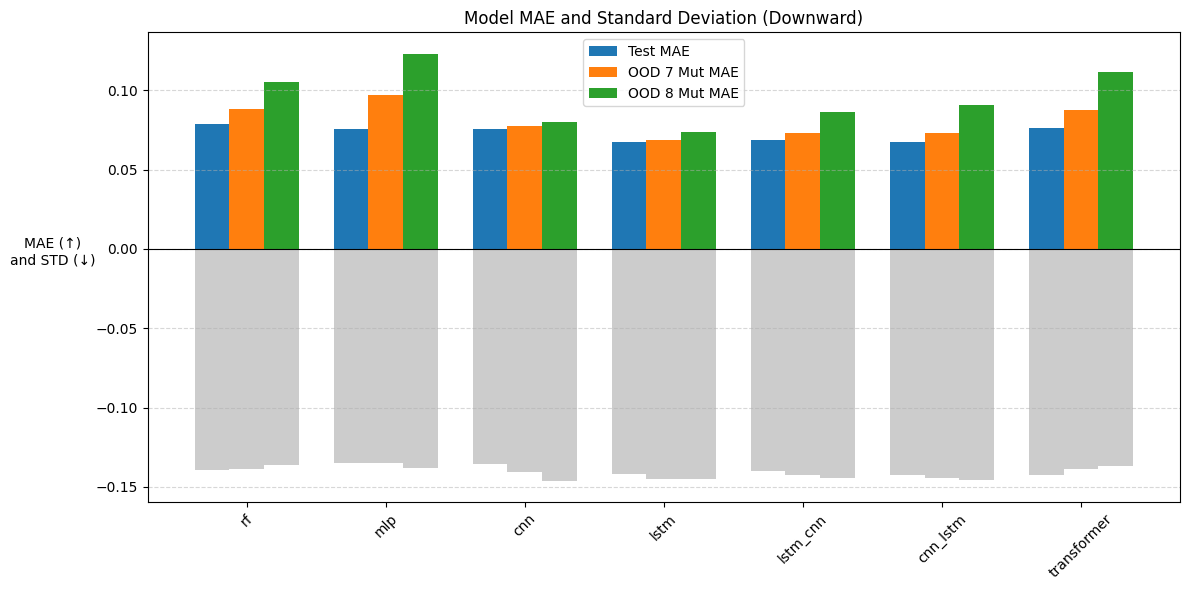

In [41]:
plot_mae_with_downward_std(df_results)

In [42]:
load_models = True

In [43]:
mutation_data_dict = {}

for i in range(9):
    mutation_mask = (mutation_distances == i)
    cur_dict = {
        'x_data': x_data[mutation_mask],
        'y_data': y_data[mutation_mask]
    }
    mutation_data_dict[i] = cur_dict

In [44]:
import umap.umap_ as umap
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

def fit_umap(x_onehot: np.ndarray, n_neighbors=10, min_dist=0.1, random_state=42, save_path="umap_model.pkl"):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_onehot)

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = reducer.fit_transform(x_scaled)

    joblib.dump((reducer, scaler), save_path)
    return embedding

def get_umap_coords(x_all_onehot, umap_model_file):
    
    reducer, scaler = joblib.load(umap_model_file)
    x_scaled = scaler.transform(x_all_onehot)
    umap_coords = reducer.transform(x_scaled)
    
    return umap_coords

def transform_umap(x_onehot, load_path="umap_model.pkl"):
    reducer, scaler = joblib.load(load_path)
    x_scaled = scaler.transform(x_onehot)
    return reducer.transform(x_scaled)

def mutate_sequence(seq, n_mutations=1, num_classes=4):
    seq = seq.copy()
    indices = np.random.choice(len(seq), size=n_mutations, replace=False)
    for idx in indices:
        options = [x for x in range(num_classes) if x != seq[idx]]
        seq[idx] = np.random.choice(options)
    return seq

def evaluate_mutants(base_seq, model, f_true, num_mutations_list=[1, 2, 3], num_variants=50):
    results = []
    base_seq = base_seq.astype(int)
    for n_mut in num_mutations_list:
        for _ in range(num_variants):
            mutant = mutate_sequence(base_seq, n_mutations=n_mut)
            x_onehot = np.eye(4)[mutant].flatten().reshape(1, -1)
            y_pred = model(torch.tensor(x_onehot, dtype=torch.float32)).item()
            y_true = f_true(mutant.reshape(1, -1))[0]
            results.append((n_mut, y_true, y_pred, mutant))
    return results

def plot_fitness_landscape(embedding, fitness, title="Fitness", cmap='viridis'):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=fitness, cmap=cmap, s=10)
    plt.colorbar(label='Fitness')
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

def plot_umap_by_mutation(umap_coords, labels, target_mutations=(7, 8)):
    plt.figure(figsize=(8, 6))

    for mut_class in np.unique(labels):
        coords = umap_coords[labels == mut_class]
        if mut_class in target_mutations:
            plt.scatter(coords[:, 0], coords[:, 1], label=f"{mut_class} mutations", s=10)
        else:
            plt.scatter(coords[:, 0], coords[:, 1], color="lightgrey", alpha=0.2, s=5)

    plt.legend()
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title("UMAP Clustering by Mutation Count")
    plt.tight_layout()
    plt.show()

C:\Users\kroep\anaconda3\envs\ps_msc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
x_all = np.concatenate([v['x_data'] for v in mutation_data_dict.values()])
mutation_labels = np.concatenate([
    np.full(len(v['x_data']), mut_class) for mut_class, v in mutation_data_dict.items()
])

x_all_onehot = np.eye(4)[x_all].reshape(len(x_all), -1)

In [46]:
if not load_models:
    for n_neighbors in [10, 30, 50, 100]:
        for min_dist in [0, 0.1, 0.3, 0.5]:
            save_path = f"umap_models\\umap_{n_neighbors}_neighbors_{str(min_dist).replace('.', '')}_min_dist.pkl"
            print(save_path)

            umap_coords = fit_umap(
                x_all_onehot, n_neighbors=n_neighbors, min_dist=min_dist, save_path=save_path
            )

In [47]:
if load_models:
    root_dir = "umap_models"
    file_set = set()

    for dir_, _, files in os.walk(root_dir):
        for file_name in files:
            rel_dir = os.path.relpath(dir_, root_dir)
            rel_file = os.path.join(rel_dir, file_name)
            file_set.add(rel_file)

    file_list = [os.path.join(root_dir, file.split('\\')[-1]) for file in list(file_set)]
    
    umap_coords_dict = {}
    
    for file in file_list:

        umap_coords = get_umap_coords(
            x_all_onehot=x_all_onehot,
            umap_model_file=file
        )
        
        umap_coords_dict[file] = umap_coords
        
        # plot_umap_by_mutation(umap_coords_sampled, mutation_labels, target_mutations=(7, 8))
    

umap_models\umap_100_neighbors_1_min_dist.pkl


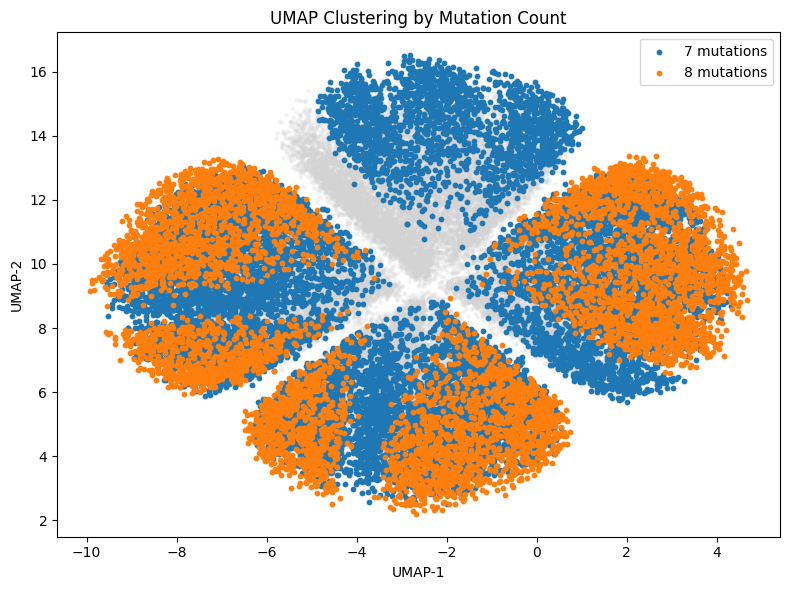

umap_models\umap_50_neighbors_03_min_dist.pkl


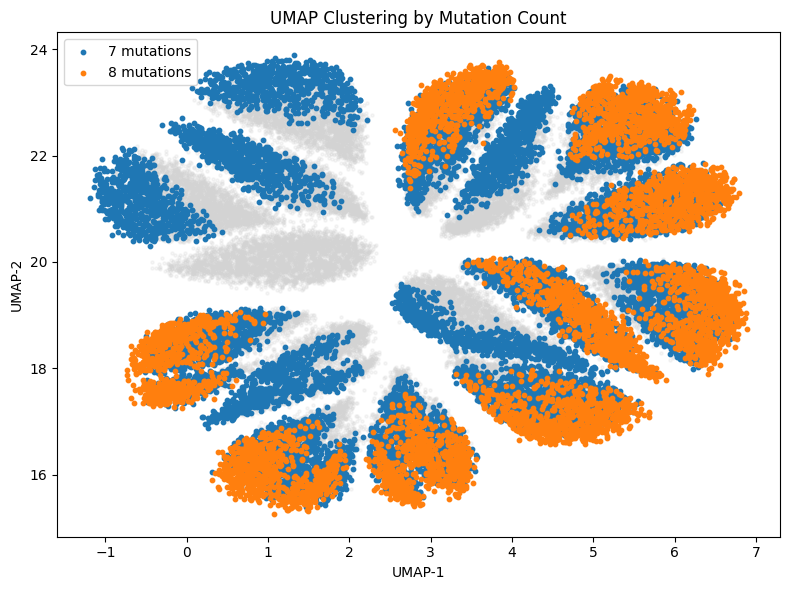

umap_models\umap_50_neighbors_0_min_dist.pkl


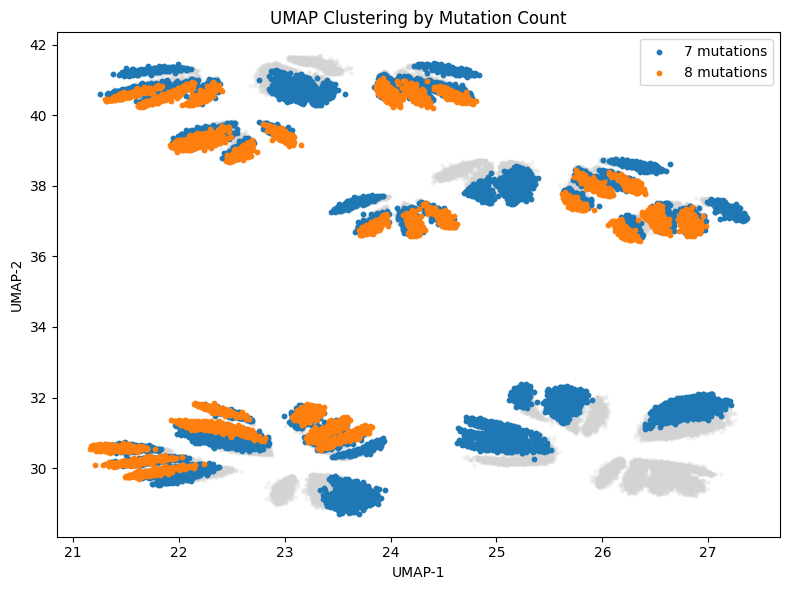

umap_models\umap_100_neighbors_01_min_dist.pkl


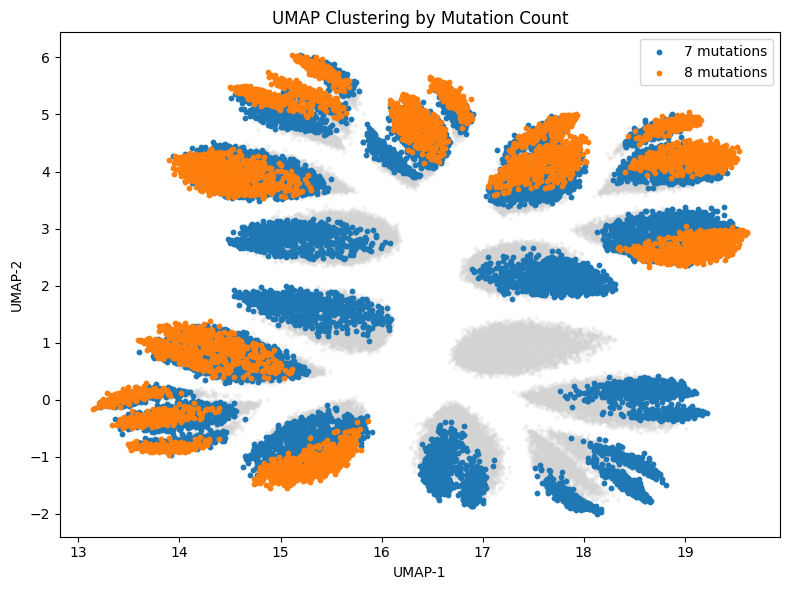

umap_models\umap_10_neighbors_0_min_dist.pkl


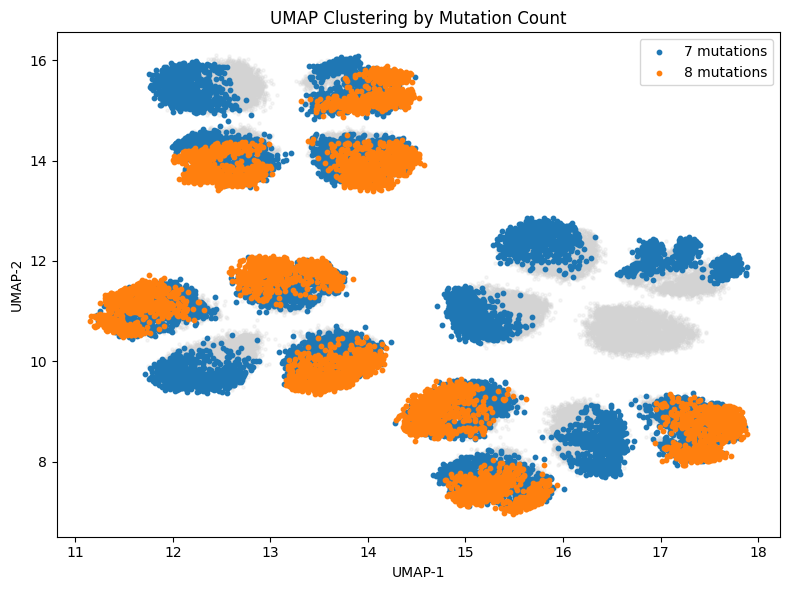

umap_models\umap_30_neighbors_03_min_dist.pkl


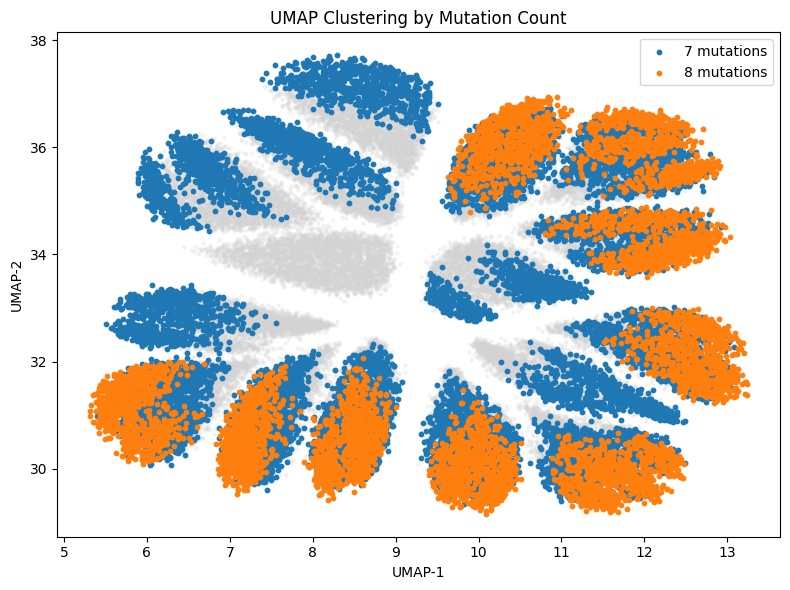

umap_models\umap_30_neighbors_1_min_dist.pkl


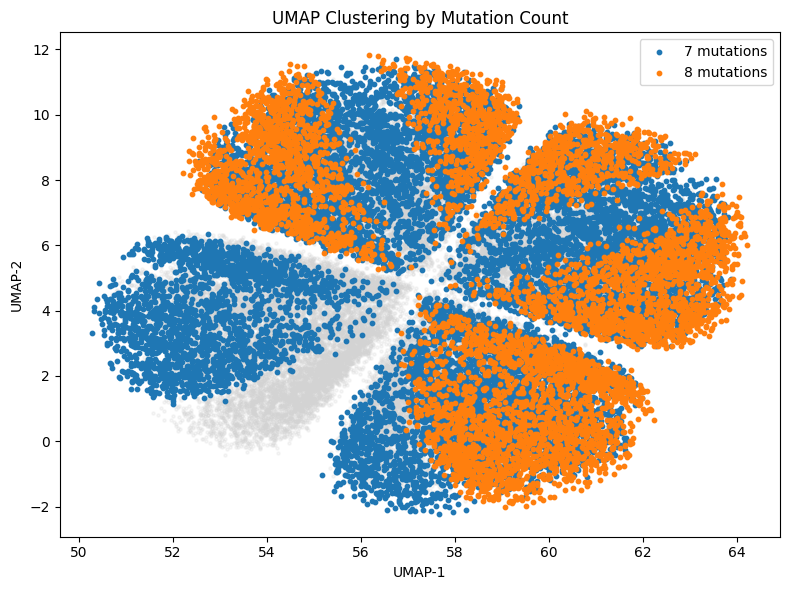

umap_models\umap_50_neighbors_1_min_dist.pkl


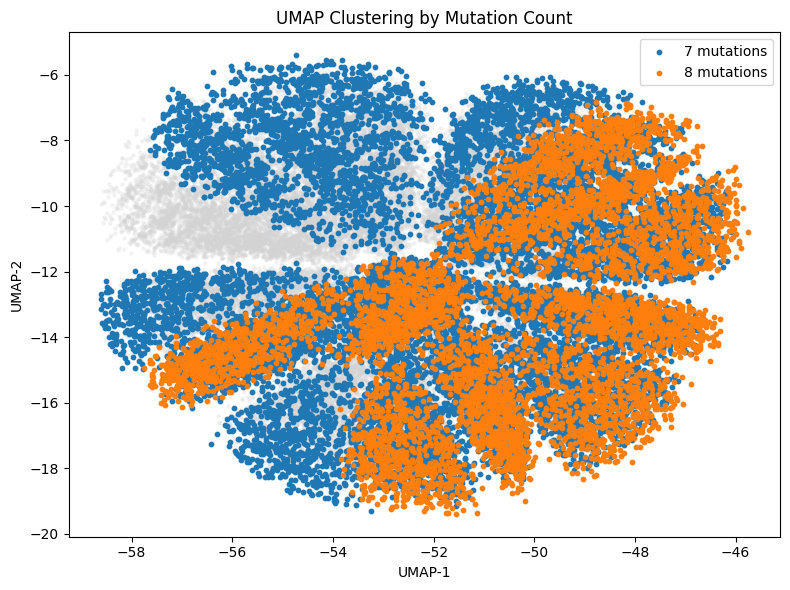

umap_models\umap_3_neighbors_005_min_dist.pkl


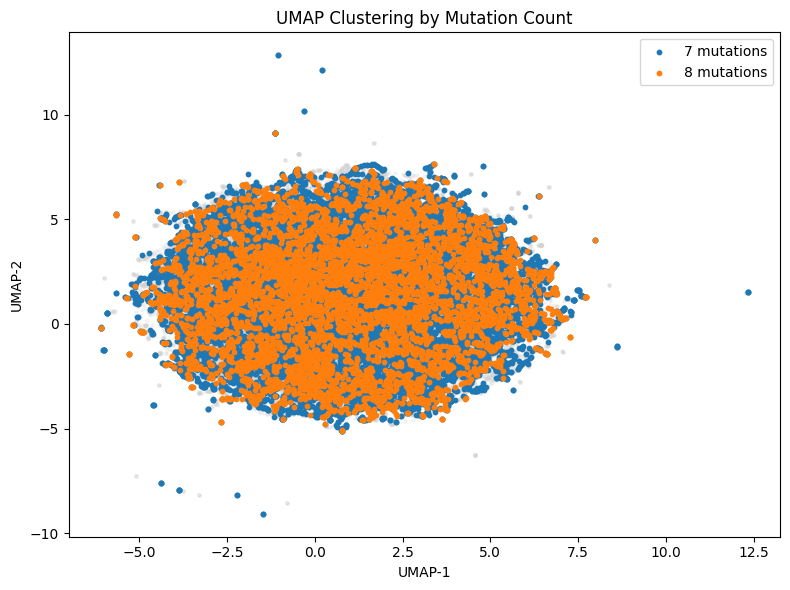

umap_models\umap_30_neighbors_0_min_dist.pkl


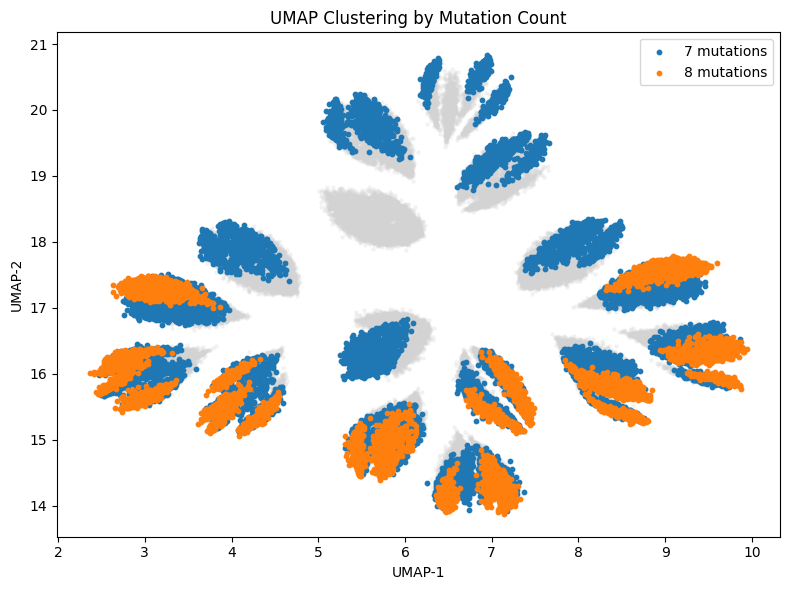

umap_models\umap_100_neighbors_03_min_dist.pkl


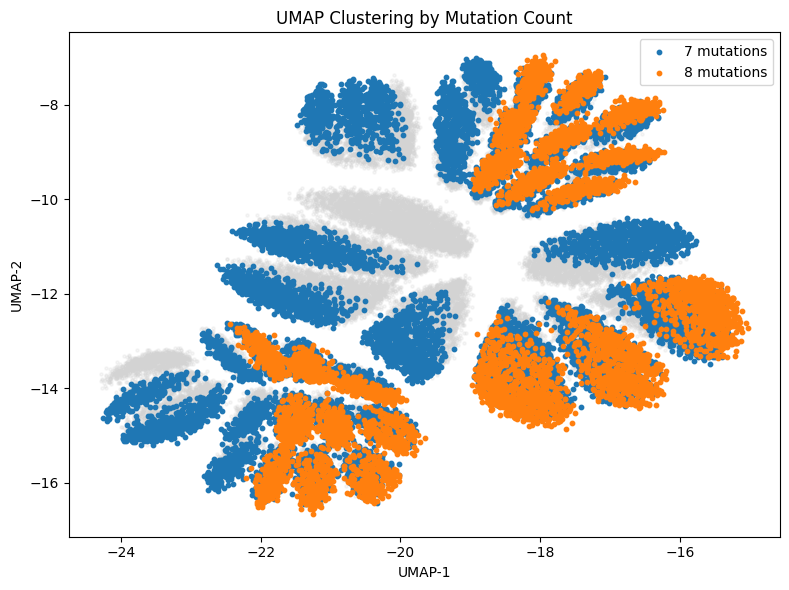

umap_models\umap_50_neighbors_01_min_dist.pkl


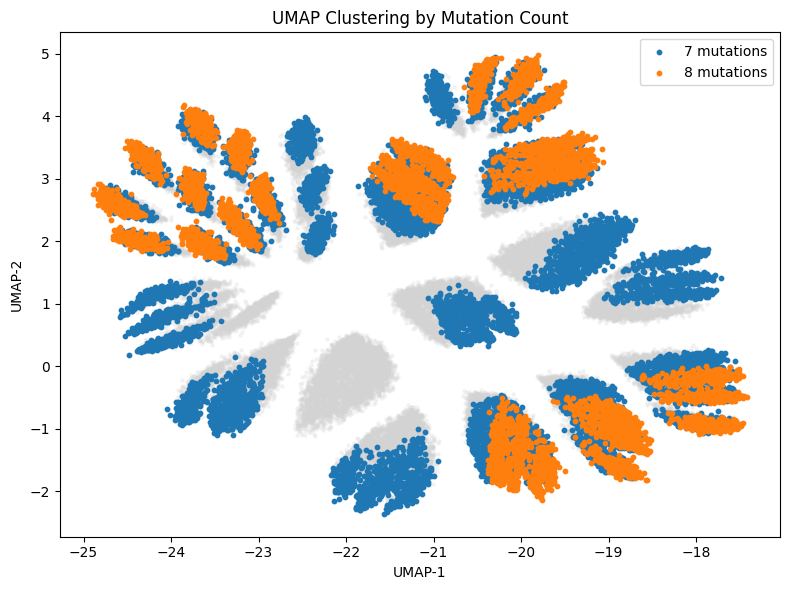

umap_models\umap_100_neighbors_0_min_dist.pkl


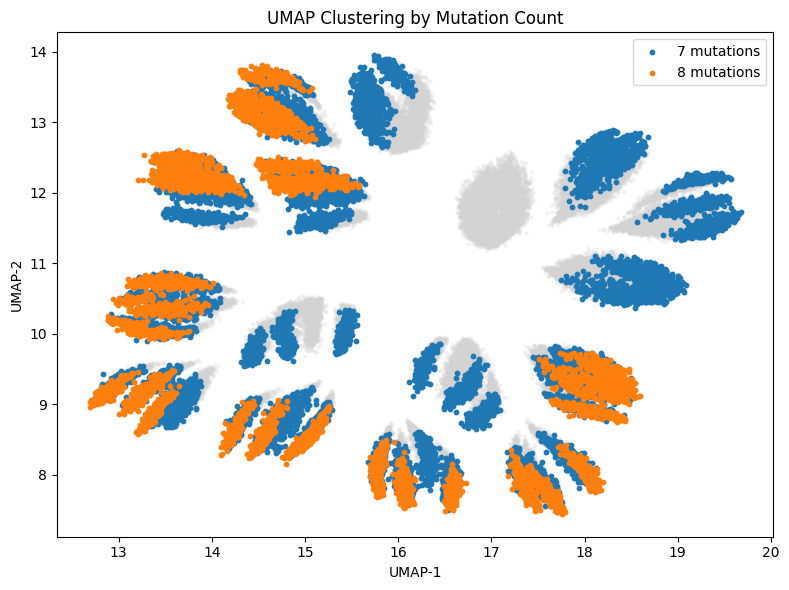

umap_models\umap_10_neighbors_05_min_dist.pkl


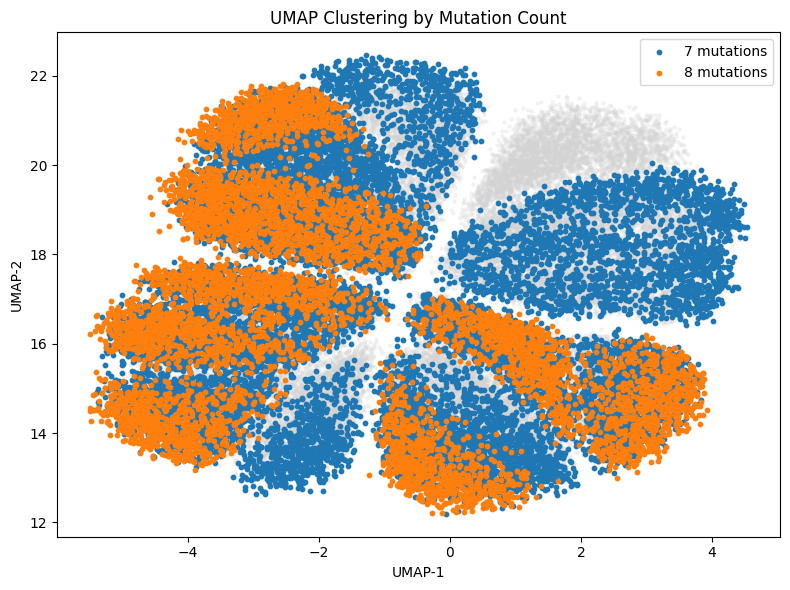

umap_models\umap_100_neighbors_05_min_dist.pkl


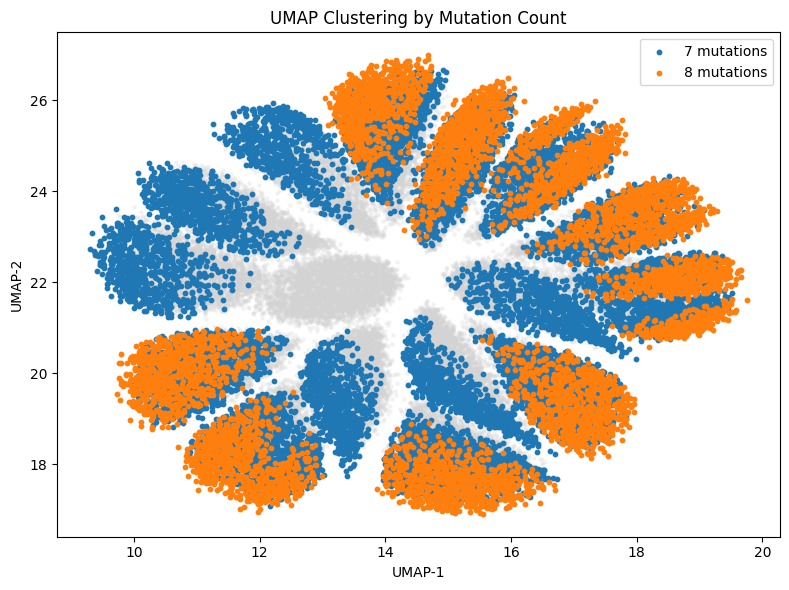

umap_models\umap_10_neighbors_01_min_dist.pkl


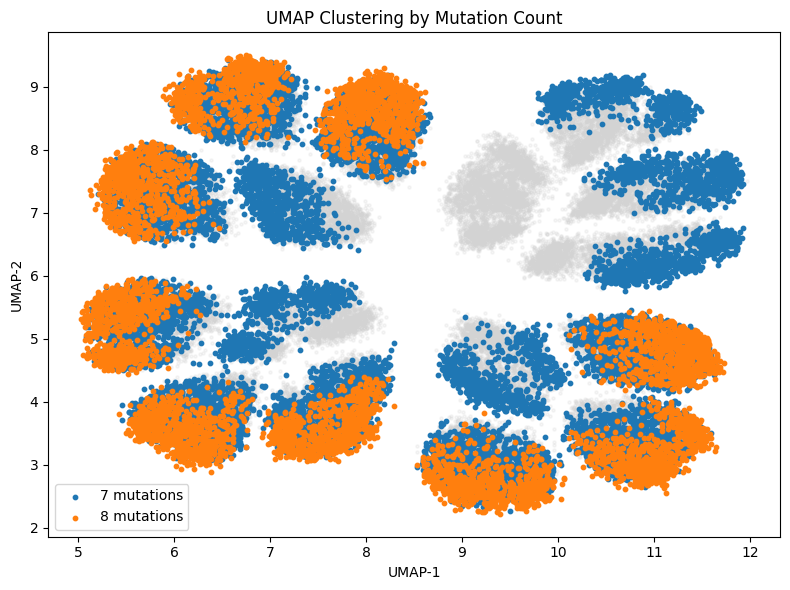

umap_models\umap_50_neighbors_05_min_dist.pkl


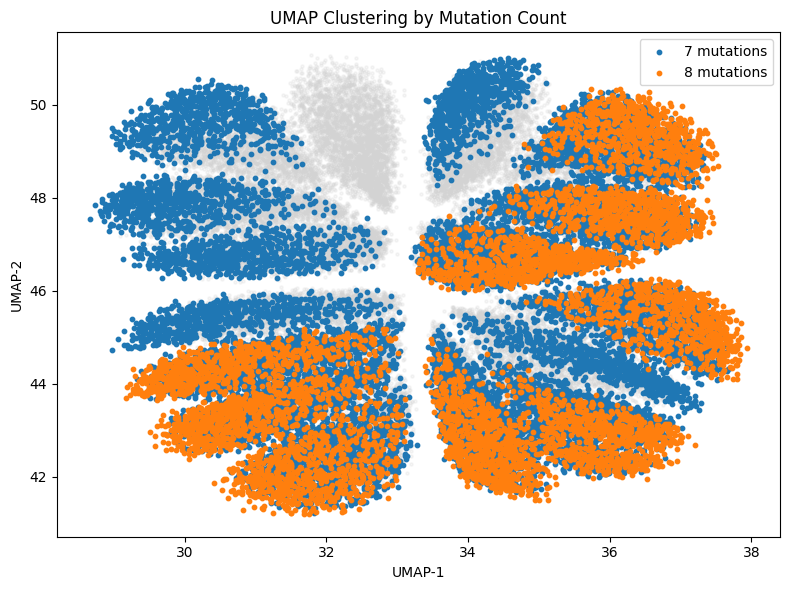

umap_models\umap_30_neighbors_01_min_dist.pkl


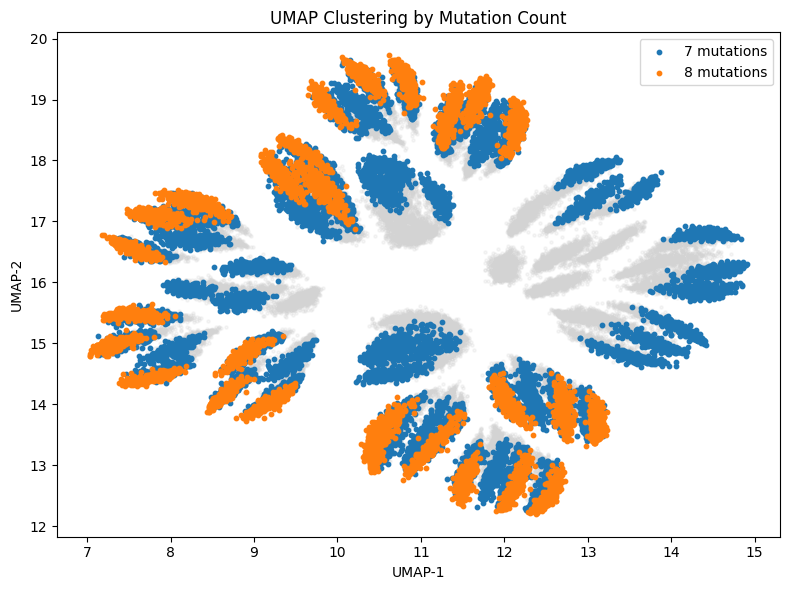

umap_models\umap_10_neighbors_03_min_dist.pkl


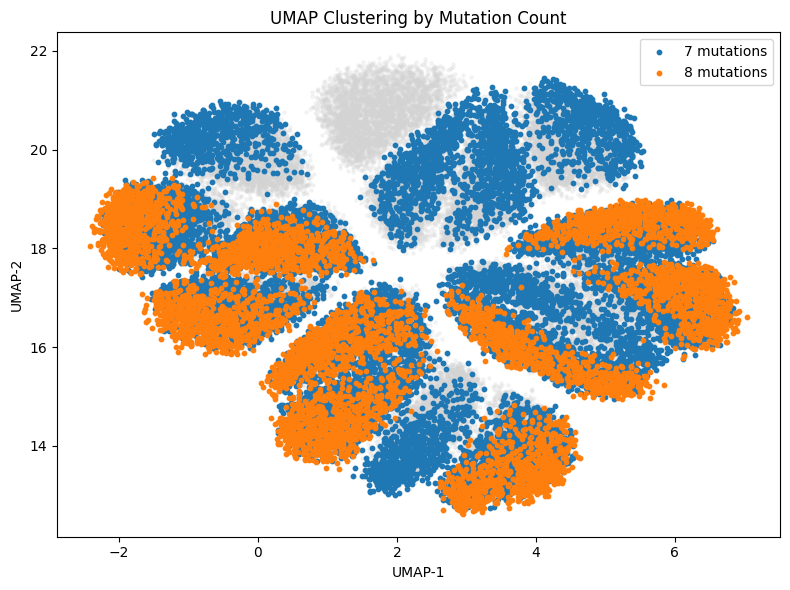

umap_models\umap_10_neighbors_1_min_dist.pkl


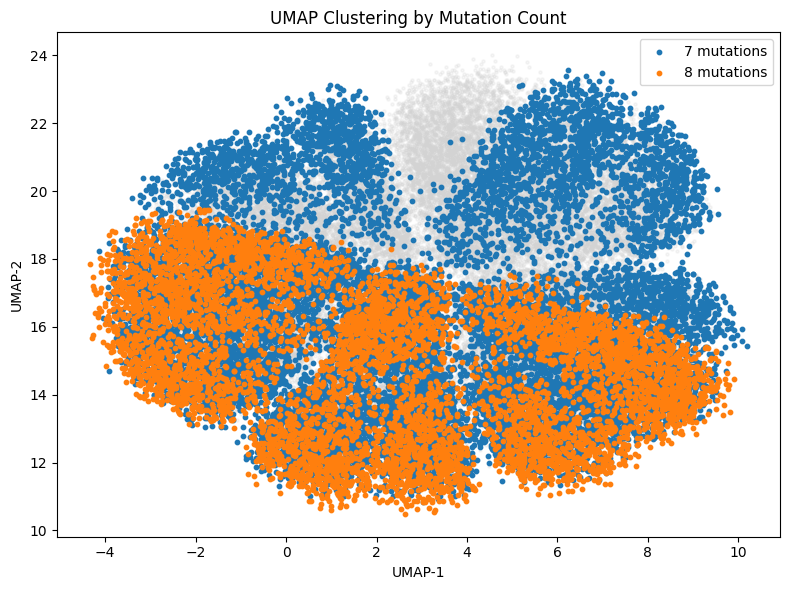

umap_models\umap_30_neighbors_05_min_dist.pkl


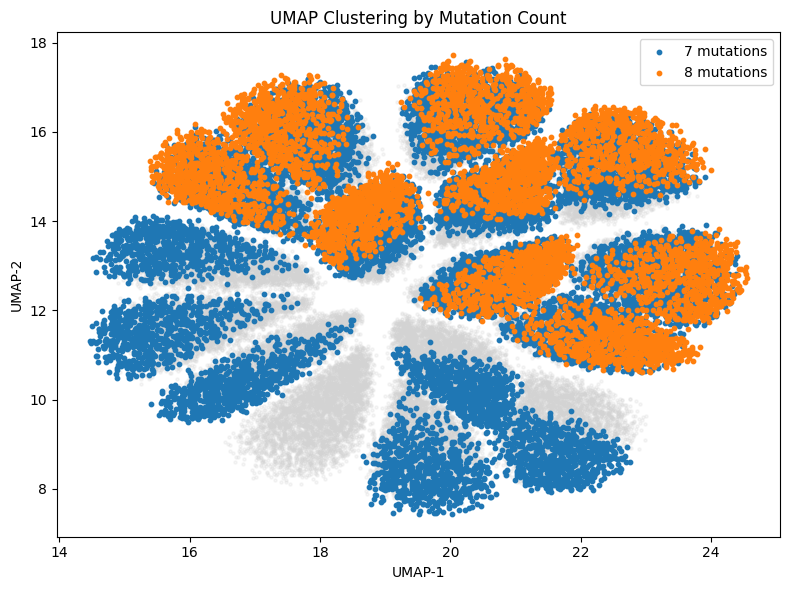

umap_models\umap_3_neighbors_05_min_dist.pkl


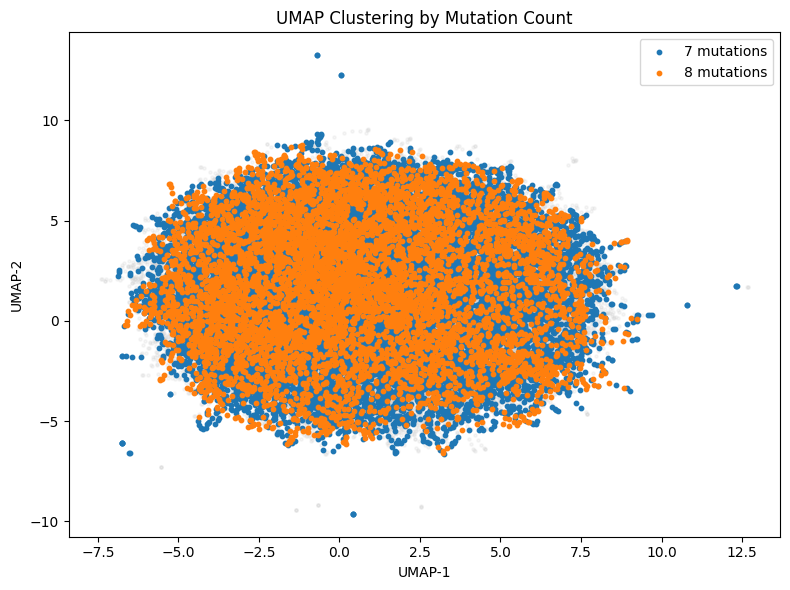

In [48]:
for file in umap_coords_dict.keys():
    print(file)
    plot_umap_by_mutation(
        umap_coords_dict[file], mutation_labels, target_mutations=(7, 8)
    )

In [49]:
# choose the best representation
umap_coords = umap_coords_dict['umap_models\\umap_30_neighbors_01_min_dist.pkl']

### Fitness Landscape

In [50]:
mutation_data_dict = {}

for i in range(9):
    mutation_mask = (mutation_distances == i)
    cur_dict = {
        'x_data': x_data[mutation_mask],
        'y_data': y_data[mutation_mask]
    }
    mutation_data_dict[i] = cur_dict

In [51]:
x_all = np.concatenate([v['x_data'] for v in mutation_data_dict.values()])
y_all = np.concatenate([v['y_data'] for v in mutation_data_dict.values()])

mutation_labels = np.concatenate([
    np.full(len(v['x_data']), mut_class) for mut_class, v in mutation_data_dict.items()
])

x_all_onehot = np.eye(4)[x_all].reshape(len(x_all), -1)

In [52]:
y_pred_all = predict_y_values(
    folder='results\\training\\random_search_2025-10-02-08-04',
    model_names=['lstm'],
    x_test=x_all
)

Predicting with model: lstm


C:\Users\kroep\Desktop\AI\ps_master_new\code\ps_functions\evaluate_best_models.py:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_encoded_torch = torch.tensor(X_test_encoded, dtype=torch.float32).to(device)


 → Done: lstm, predicted 65536 samples.


In [53]:
len(x_all) == len(mutation_labels) == len(y_pred_all['lstm'])

True

In [54]:
def plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations,
    y_true,
    y_pred,
    cmap="viridis",
    figsize=(12, 10),
    use_abs_error=False
):
    # mask for chosen mutations
    mask = np.isin(mutation_labels, selected_mutations)
    if not np.any(mask):
        print(f"No samples found for mutation classes {selected_mutations}")
        return

    Z   = np.asarray(umap_coords)[mask]
    y_t = np.ravel(np.asarray(y_true)[mask])
    y_p = np.ravel(np.asarray(y_pred)[mask])

    if Z.shape[0] != y_t.shape[0]:
        print(f"Shape mismatch: points={Z.shape[0]}, y_true={y_t.shape[0]}")
        return
    
    diff = np.abs(y_p - y_t) if use_abs_error else (y_p - y_t)

    # limits for colors
    vmin = np.min([y_t.min(), y_p.min()])
    vmax = np.max([y_t.max(), y_p.max()])
    if use_abs_error:
        dmin, dmax = 0.0, diff.max()
        diff_cmap = "viridis"
        diff_label = "Absolute error"
    else:
        dmax = np.max(np.abs(diff))
        dmin, dmax = -dmax, dmax
        diff_cmap = "coolwarm"
        diff_label = "Prediction difference"

    # figure layout for 2 columns in the top row and 1 big plot below
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1.2])

    ax_true = fig.add_subplot(gs[0, 0])
    ax_pred = fig.add_subplot(gs[0, 1])
    ax_diff = fig.add_subplot(gs[1, :])

    # plot true values
    sc1 = ax_true.scatter(Z[:, 0], Z[:, 1], c=y_t, cmap=cmap, s=15, vmin=vmin, vmax=vmax)
    ax_true.set_title(f"True fitness (mutations {selected_mutations})")
    ax_true.set_xlabel("UMAP-1")
    ax_true.set_ylabel("UMAP-2")

    # plot predictions
    sc2 = ax_pred.scatter(Z[:, 0], Z[:, 1], c=y_p, cmap=cmap, s=15, vmin=vmin, vmax=vmax)
    ax_pred.set_title("Predicted fitness")
    ax_pred.set_xlabel("UMAP-1")
    ax_pred.set_ylabel("UMAP-2")

    # difference plot
    sc3 = ax_diff.scatter(Z[:, 0], Z[:, 1], c=diff, cmap=diff_cmap, s=20, vmin=dmin, vmax=dmax)
    ax_diff.set_title(f"{diff_label} (Pred − True)")
    ax_diff.set_xlabel("UMAP-1")
    ax_diff.set_ylabel("UMAP-2")
    
    fig.colorbar(sc2, ax=[ax_true, ax_pred], shrink=0.8, label="Fitness value")
    fig.colorbar(sc3, ax=ax_diff, shrink=0.8, label=diff_label)

    plt.show()

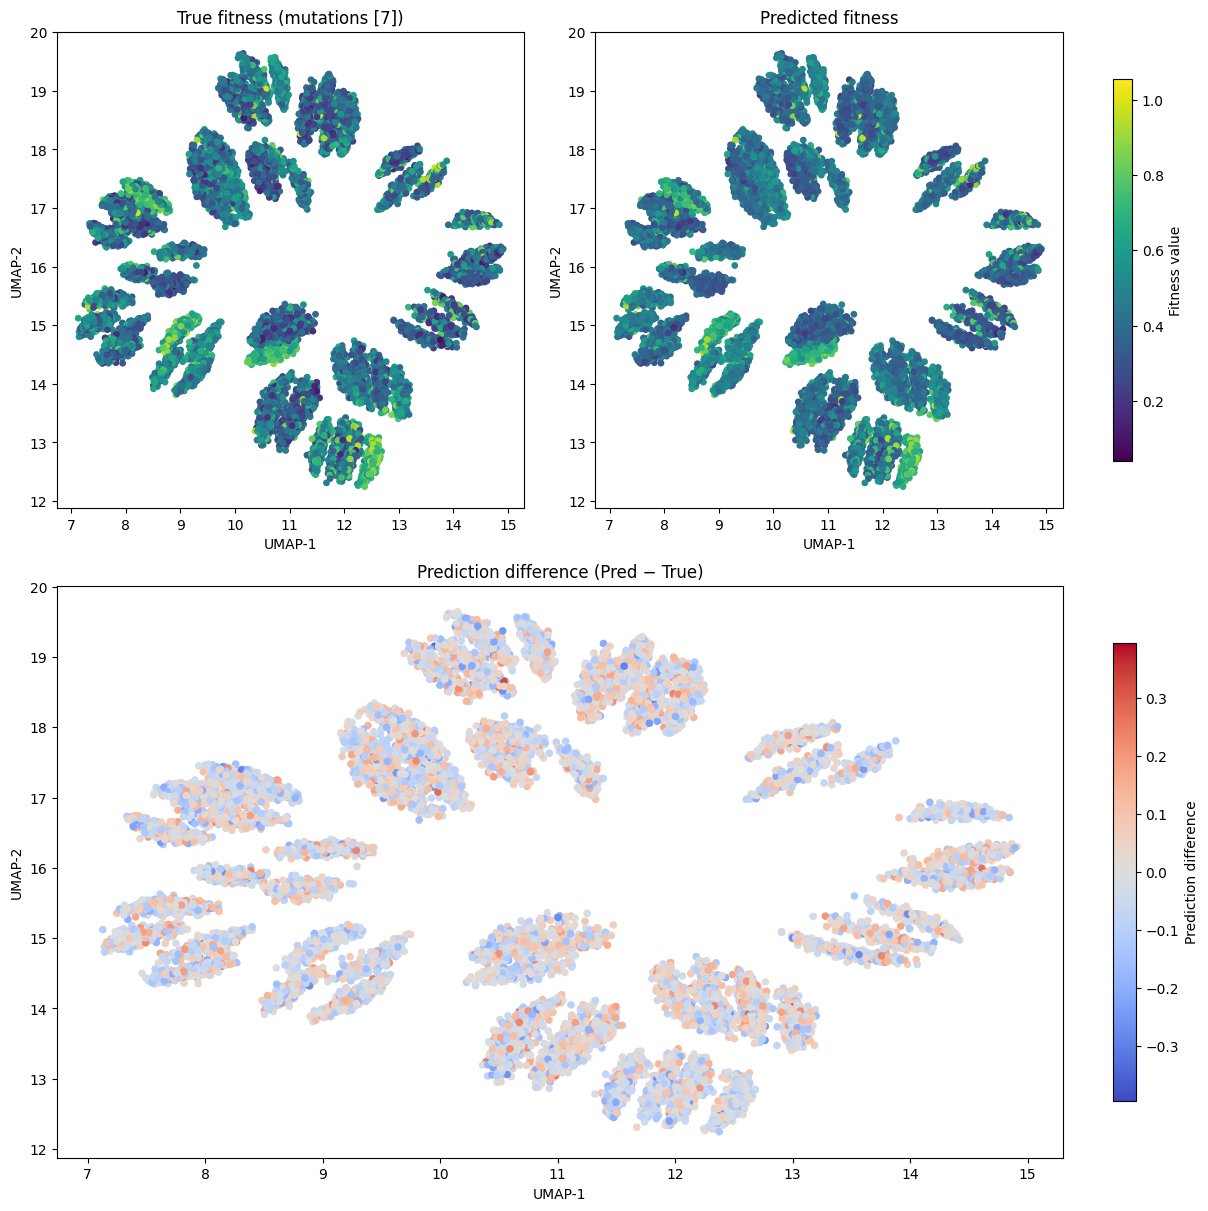

In [55]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[7],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
) 

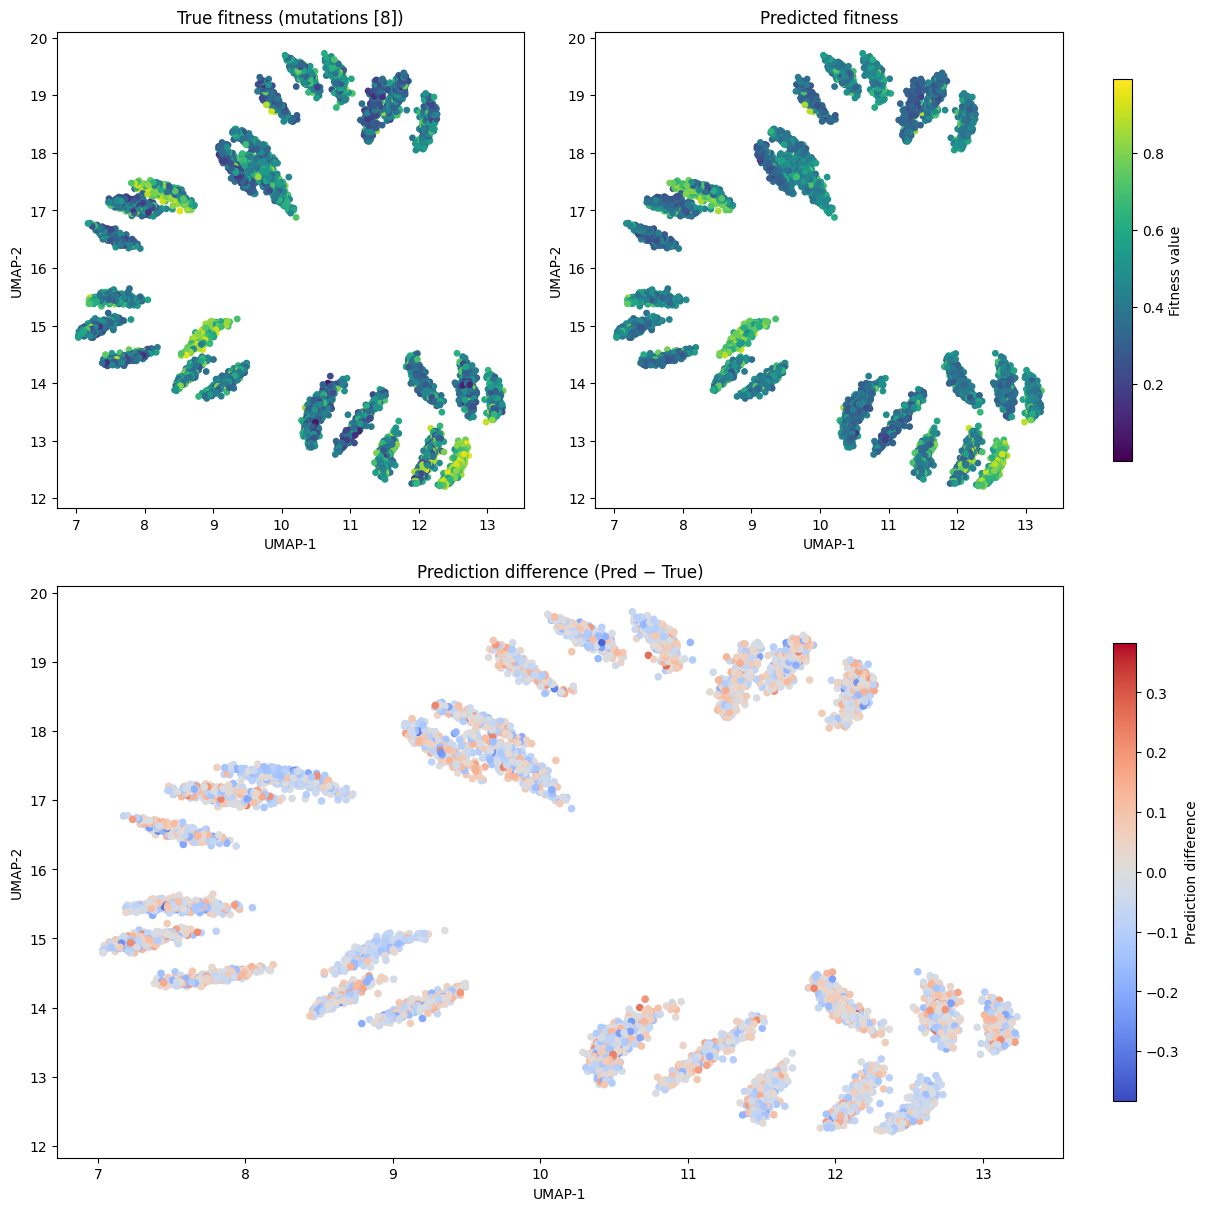

In [56]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[8],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
) 

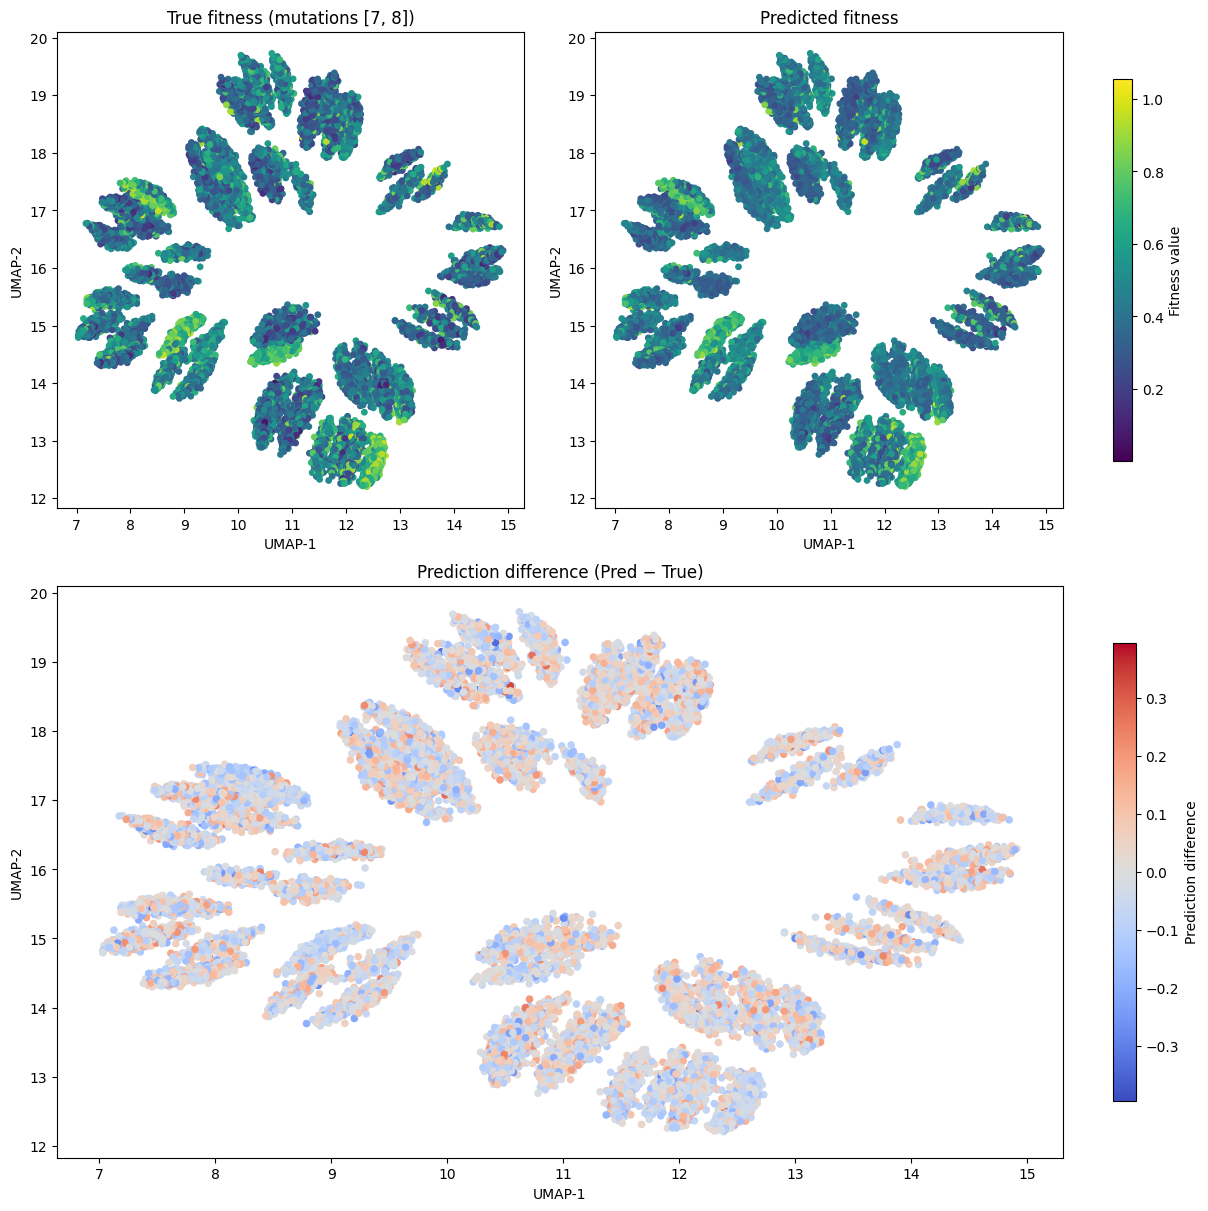

In [57]:
plot_umap_true_vs_pred(
    umap_coords,
    mutation_labels,
    selected_mutations=[7,8],
    y_true=y_all,
    y_pred=y_pred_all['lstm'],
    figsize=(12, 12)
) 